## Week 2 Lab exercises

In this week we will use python to explore strange new worlds, to seek out new life and new civilisation, and to boldly code what no one has coded before. 

The goal is to familiarise yourself with using functions, loops, arrays and plotting in Python, and to illustrate some of the software carpentry points that we discussed in the lecture.

In [113]:
# first we import the libraries we need
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

import time

# The following lines makes the plots appear in another window - if using AppsAnywhere they may appear
# in another window behind the notebook, and you may have to rearrange the desktop to see them.
# %matplotlib
# ^ evil -- breaks the kernel

### Defining functions

In [114]:
# Function that generates random asteroids
def generate_asteroids(minshara = False):
    # Customise the length of the field
    length = 20
    asteroids = []
    minsharas = []

    for i in range(1, length):
        possible_ys = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
        if np.random.uniform() > 0.3:
            new = possible_ys.pop(np.random.choice(possible_ys))
            asteroids.append([i, new])
            if np.random.uniform() > 0.6:
                new = possible_ys.pop(np.random.choice(possible_ys))
                asteroids.append([i, new])
        if np.random.uniform() > 0.6:
            new = possible_ys.pop(np.random.choice(possible_ys))
            minsharas.append([i, new])
    
    return asteroids, minsharas

asteroids, minsharas = generate_asteroids()

In [115]:
# Function that generates a map given asteroids and minsharas
def generate_map(asteroid_locations, minshara_locations = None):
    if minshara_locations:
        all_locations = np.concatenate((asteroid_locations, minshara_locations), axis=0)
    else:
        all_locations = asteroid_locations
    max_up = int(max(all_locations, key=lambda x: x[1])[1])
    max_down = int(min(all_locations, key=lambda x: x[1])[1])
    start = -max_down + 1
    height = max_up - max_down + 3
    length = int(max(all_locations, key=lambda x: x[0])[0]) + 3
    
    map = np.zeros((length, height))
    for location in asteroid_locations :
        map[int(location[0])][int(location[1]) - max_down + 1] = -100
    if minshara_locations:
        for location in minshara_locations :
            map[int(location[0])][int(location[1]) - max_down + 1] = -50

    map[0][-max_down + 1] = 1

    return map, length-1, height, start

In [116]:
# Function that generates graph representing the distances and connections between positions
def generate_graph(map, height, length, start):
    grid = [[0 for x in range(height * length + 1)] for y in range(height * length + 1)]

    # distances from initial position
    for coordinate_next in range(0, height):
        # Find the coordinates of the asteroids in this and next column
        asteroid_next_ys = [int(location) for location in range(len(map[1])) if map[1][location] == -100]
        asteroid_current_ys = [int(location) for location in range(len(map[0])) if map[0][location] == -100]
        if coordinate_next not in asteroid_next_ys:
            if coordinate_next == start:
                grid[0][coordinate_next+1] = 1
            
            available = True
            for asteroid in asteroid_next_ys:
                if (asteroid > coordinate_next and asteroid < start) or (asteroid < coordinate_next and asteroid > start):
                    if np.absolute(asteroid - coordinate_next)/np.sqrt((start - coordinate_next)**2 + 1) <= 0.5:
                        available = False
            
            for asteroid in asteroid_current_ys:
                if (asteroid > coordinate_next and asteroid < start) or (asteroid < coordinate_next and asteroid > start):
                    if np.absolute(asteroid - start)/np.sqrt((start - coordinate_next)**2 + 1) <= 0.5:
                        available = False          
                    
            if available:
                if map[1][coordinate_next] == -50:
                    grid[0][coordinate_next+1] = np.sqrt((start - coordinate_next)**2 + 1) - 50
                else:
                    grid[0][coordinate_next+1] = np.sqrt((start - coordinate_next)**2 + 1)
                        
    # distances from other positions
    for current_time in range(1, length):
        for start in range(0, height):
            for coordinate_next in range(0, height):
                # Find the coordinates of the asteroids in this and next column
                asteroid_next_ys = [int(location) for location in range(len(map[current_time+1])) if map[current_time+1][location] == -100]
                asteroid_current_ys = [int(location) for location in range(len(map[current_time])) if map[current_time][location] == -100]
                if coordinate_next not in asteroid_next_ys:
                    if coordinate_next == start:
                        grid[1+(current_time-1)*height+start][coordinate_next+1+height*current_time] = 1
                    
                    available = True
                    for asteroid in asteroid_next_ys:
                        if (asteroid > coordinate_next and asteroid < start) or (asteroid < coordinate_next and asteroid > start):
                            if np.absolute(asteroid - coordinate_next)/np.sqrt((start - coordinate_next)**2 + 1) <= 0.5:
                                available = False
                    
                    for asteroid in asteroid_current_ys:
                        if (asteroid > coordinate_next and asteroid < start) or (asteroid < coordinate_next and asteroid > start):
                            if np.absolute(asteroid - start)/np.sqrt((start - coordinate_next)**2 + 1) <= 0.5:
                                available = False    
                            
                    if available:
                        if map[current_time+1][coordinate_next] == -50:
                            grid[1+(current_time-1)*height+start][coordinate_next+1+height*current_time] = np.sqrt((start - coordinate_next)**2 + 1) - 50
                        else:
                            grid[1+(current_time-1)*height+start][coordinate_next+1+height*current_time] = np.sqrt((start - coordinate_next)**2 + 1)
                    
    return grid

In [117]:
# Function that generates the path to follow
def generate_path(asteroid_locations, minshara_locations = None):
    map, length, height, start_initially = generate_map(asteroid_locations, minshara_locations)
    start_time = time.time()
    grid = generate_graph(map, height, length, start_initially)
    end_time = time.time()

    print("Time taken to generate graph: ", end_time - start_time)

    graph = csr_matrix(grid)

    start_time = time.time()
    _, predecessors = shortest_path(csgraph=graph, directed=True, method='BF', indices=0, return_predecessors=True)

    index_end = len(grid[0]) - height + start_initially
    path = [index_end % height - 1 - start_initially]

    while predecessors[index_end] != -9999:
        next_index = predecessors[index_end] % height - 1 - start_initially
        if predecessors[index_end] % height == 0:
            next_index = height - 1 - start_initially
        path.append(next_index)
        index_end = predecessors[index_end]

    path.reverse()
    path[0] = 0

    end_time = time.time()
    print("Time taken to find path: ", end_time - start_time)

    return path

In [118]:
def get_distance(path):
    distance = 0
    for i in range(1, len(path)):
        distance += np.sqrt((path[i] - path[i-1])**2 + 1)
    return distance

In [119]:
def plot_map_and_path(ax,asteroid_locations, minshara_locations = None) :
    _, length, height, start = generate_map(asteroid_locations, minshara_locations)
    path = generate_path(asteroid_locations, minshara_locations)

    print("Path taken: ", path)

    plt.axis([0, length, -start, height - start - 1])
    major_ticks_xs = np.arange(0, length, 1)
    major_ticks_ys = np.arange(-start, height - start, 1)
    ax.set_xticks(major_ticks_xs)
    ax.set_yticks(major_ticks_ys)
    plt.xlabel("time / x position")
    plt.ylabel("position")
    ax.set_aspect('equal')
    ax.grid(which='major', alpha=0.8)

    for location in asteroid_locations :
        circle=plt.Circle(location, 0.5 , color='r')
        ax.add_artist(circle)

    if minshara_locations is not None:
        for location in minshara_locations :
            circle=plt.Circle(location, 0.5 , color='b')
            ax.add_artist(circle)

    list_of_times = np.arange(0, length+1, 1)
    
    # go through the list of times, where index is the index within the 
    # list, and time_now is the entry at that index
    for index, time_now in enumerate(list_of_times) :
        position_now = path[index]
        ax.plot(time_now, position_now, 'o')

    ax.plot(list_of_times, path, 'g-')

    print("Distance travelled: ", get_distance(path))

Time taken to generate graph:  0.019335269927978516
Time taken to find path:  0.00110626220703125
Path taken:  [0, -1, -2, -3, -4, -4, -4, -4, 3, 3, 3, 1, -1, 0, 3, 1, -3, -2, -1, -1, -1, 0]
Distance travelled:  39.37836352913563


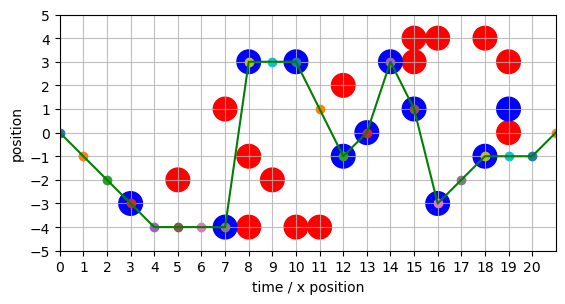

In [152]:
random_asteroids, random_minsharas = generate_asteroids(minshara = True)

fig = plt.figure()
ax = plt.gcf().gca()
plot_map_and_path(ax, random_asteroids, random_minsharas)

### ACTIVITY 1: 
In the code below, change the line as marked (UPDATE ME) to get the asteroid data from the data file `asteroid_locations.dat` that is in the `/data` folder

In [121]:
ex1_asteroid_locations = np.loadtxt('data/asteroid_locations.dat')

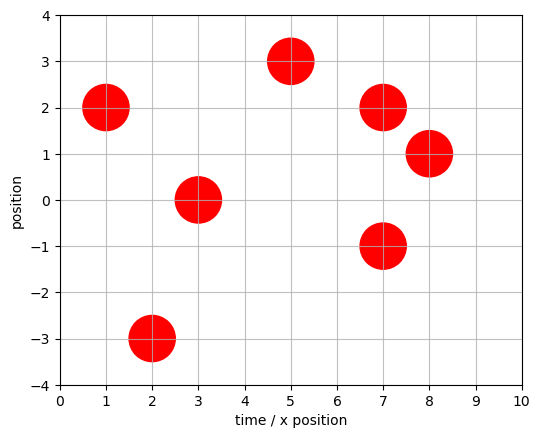

In [138]:
# Set up the plotting
def plot_asteroid_field(ax) :
    plt.axis([0,10,-4,4])
    major_ticks = np.arange(0, 11, 1)
    ax.set_xticks(major_ticks)
    plt.xlabel("time / x position")
    plt.ylabel("position")
    ax.set_aspect('equal')
    ax.grid(which='major', alpha=0.8)

    # Mark the asteroid positions onto the plot - read in the data from data/asteroid_locations.dat
    # HINT: the function you need is called loadtxt
    for location in ex1_asteroid_locations :
        circle=plt.Circle(location, 0.5 , color='r')
        ax.add_artist(circle)
    # plt.pause(0.3)

# Test the plot
fig = plt.figure()
ax = plt.gcf().gca()
plot_asteroid_field(ax)

In [139]:
# set up a list to store the times and positions
list_of_times = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
list_of_y_positions = np.zeros_like(list_of_times)

# print off the initial values of the times and positions
print("The list of times at the start is ", list_of_times)
print("The list of y positions at the start is ", list_of_y_positions)

The list of times at the start is  [ 0  1  2  3  4  5  6  7  8  9 10]
The list of y positions at the start is  [0 0 0 0 0 0 0 0 0 0 0]


### ACTIVITY 2: 

Captain Katy has asked you to plot a flight path through the asteroid field. If you run the code below you will see that the path does not currently avoid the asteroids :-( Update it so that it does! 

Also update so that the distance moved is calculated, and try to minimise this.

RULES:

- Just like in a retro video game, the ship must move one step forward in the x direction at every timestep, and you can only change its movement in the y direction to avoid the asteroids.
- You should move in whole steps in the (x and) y direction, so you are always on integer coordinates.
- You must end the flight back at position y=0.
- Don't hit the asteroids! Note that their radius is 0.5 of a distance unit, so it is not sufficient to simply avoid the coordinates on which they are centred.

#### BUT FIRST

Remember *defensive programming*? You will see that the code does not check that it does what it should - i.e., it does not check that we have not hit an asteroid, and that we return to the zero position at the last step. Implement tests to check the rules _BEFORE_ you implement the code to set the path, and use asserts to make it quit with an error message if it fails.

*TIP: You probably want to write any tests as a separate function. Would it be better to call them at each step or just at the end?*

Time taken to generate graph:  0.0040285587310791016
Time taken to find path:  0.0012569427490234375
[0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0]
The list of times at the end is  [ 0  1  2  3  4  5  6  7  8  9 10]
The list of y positions at the end is  [0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0]


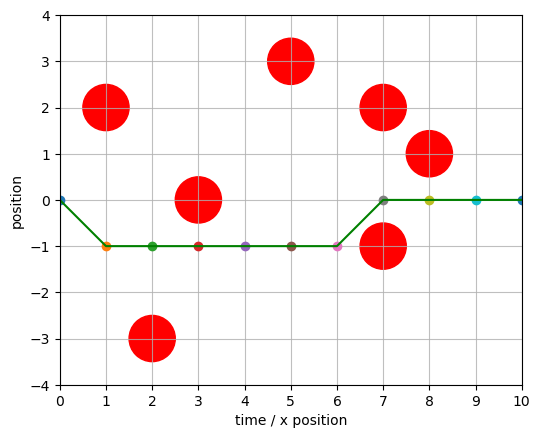

I moved a total of  0  units


In [140]:
# Plot again the asteroid field, so that we can plot the path on top of it
plt.ion() # Make the plotting interactive so we can update the path as we fly
fig = plt.figure()
ax = plt.gcf().gca() #this stands for get current figure, get current axis
plot_asteroid_field(ax)

path = generate_path(ex1_asteroid_locations)

print(path)

# go through the list of times, where index is the index within the 
# list, and time_now is the entry at that index
for index, time_now in enumerate(list_of_times) :
    position_now = path[index]
    ax.plot(time_now, position_now, 'o')
    #plt.pause(0.3) # This pause just slows down the plotting so it looks nicer

print("The list of times at the end is ", list_of_times)
print("The list of y positions at the end is ", path)

ax.plot(list_of_times, path, 'g-')
plt.show()

# Print out some information
total_distance_moved = 0 # UPDATE ME!
print("I moved a total of ", total_distance_moved, " units")

### ACTIVITY 3:

Now we are on an exploratory mission. Captian Katy wants you to plot a course for all of the blue (M or Minshara-class) planets on the map contained in `data/planet_locations.dat`, but not touching any of the other dangerous D-class pink planets. 

Again you need to update the code below to get the data from the data files.

How could the read-in of the data (in particular checking of the class of the planet) be improved?

In [142]:
planet_locations = np.loadtxt('data/planet_locations.dat')

ex2_asteroid_locations = []
ex2_minshara_locations = []

for i in planet_locations:
    if i[-1] == 0:
        ex2_asteroid_locations.append(i[:-1])
    else:
        ex2_minshara_locations.append(i[:-1])

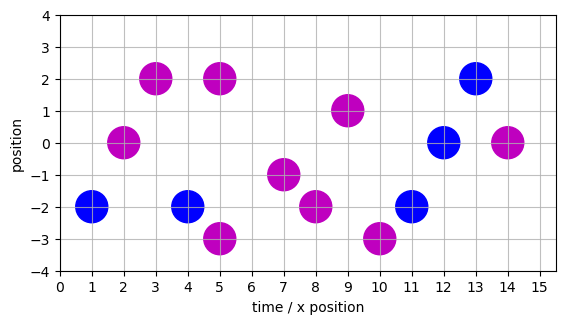

In [143]:
# Plot the planetary locations

def plot_planet_locations(ax) :
    plt.axis([0,15.5,-4,4])
    major_ticks = np.arange(0, 16, 1)
    ax.set_xticks(major_ticks)
    plt.xlabel("time / x position")
    plt.ylabel("position")
    ax.set_aspect('equal')
    ax.grid(which='major', alpha=0.8)


    for index, location in enumerate(planet_locations) :
        is_minshara_class =  (location[2] == 1)
        coordinates = np.array([location[0],location[1]])
        if(is_minshara_class) :
            circle=plt.Circle(coordinates, 0.5, color='b')
            plt.gcf().gca().add_artist(circle)
        else : # other planets are dangerous D class planets
            circle=plt.Circle(coordinates, 0.5, color='m')
            plt.gcf().gca().add_artist(circle)  

# Test the plot
fig = plt.figure()
ax = plt.gcf().gca()
plot_planet_locations(ax)

### ACTIVITY 4:

Update the code below to make sure you visit all the M class planets as your Captain has asked (same rules of motion as above). What is the shortest distance in which you can do this? Update the code to calculate your value.

Again, you should _first write code that checks that the code does what it should_, and then implement the actual actions.

The list of times at the start is  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
The list of positions at the start is  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Time taken to generate graph:  0.0070645809173583984
Time taken to find path:  0.0010066032409667969
The list of times at the end is  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
The list of positions at the end is  [0, -2, -2, -2, -2, -2, -3, -3, -3, -3, -2, -2, 0, 2, 1, 0, 0]


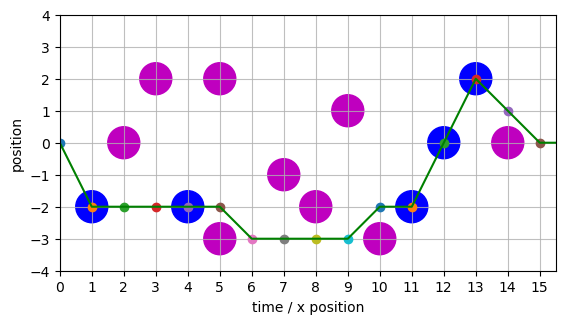

I moved a total of  0  units


In [144]:
# Plot again the asteroid field, so that we can plot the path on top of it
plt.ion() # Make the plotting interactive so we can update the path as we fly
fig = plt.figure()
ax = plt.gcf().gca()
plot_planet_locations(ax)   

# set up a list to store the times and positions
final_time = 16
list_of_times = np.arange(final_time+1)
list_of_y_positions = np.zeros_like(list_of_times)

# we want to track how much we have moved during the simulation
# so zero this
total_distance_moved = 0

# print off the initial values of the times and positions
print("The list of times at the start is ", list_of_times)
print("The list of positions at the start is ", list_of_y_positions)

# generate path
path = generate_path(ex2_asteroid_locations, ex2_minshara_locations)

# go through the list of times, where index is the index within the 
# list, and time_now is the entry at that index
for index, time_now in enumerate(list_of_times) :
    position_now = path[index]
    plt.plot(time_now, position_now, 'o')

print("The list of times at the end is ", list_of_times)
print("The list of positions at the end is ", path)

plt.plot(list_of_times, path, 'g-')
plt.show()

# Calculate and print out some information
total_distance_moved = 0
print("I moved a total of ", total_distance_moved, " units")